# Import Libraries & Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression 
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, precision_score, f1_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, VotingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# Read in Clean Data

In [2]:
hate_10k = pd.read_csv('../Data/hate10k_clean.csv')
hate_10k.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,RT mayasolovely As a woman you shouldn't comp...
1,3,0,3,0,1,RT mleew17 boy dats cold...tyga dwn bad for c...
2,3,0,3,0,1,RT UrKindOfBrand Dawg RT 80sbaby4life You eve...
3,3,0,2,1,1,RT C_G_Anderson viva_based she look like a tr...
4,6,0,6,0,1,RT ShenikaRoberts The shit you hear about me ...


# Data Inspection

In [3]:
hate_10k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               10000 non-null  int64 
 1   hate_speech         10000 non-null  int64 
 2   offensive_language  10000 non-null  int64 
 3   neither             10000 non-null  int64 
 4   class               10000 non-null  int64 
 5   tweet               10000 non-null  object
dtypes: int64(5), object(1)
memory usage: 468.9+ KB


In [4]:
hate_10k.isna().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

# Train Test Split

In [5]:
#Checking to see if I have a balanced data 
hate_10k['class'].value_counts()

1    7486
2    1734
0     780
Name: class, dtype: int64

In [6]:
hate_10k['class'].value_counts(normalize=True)

1    0.7486
2    0.1734
0    0.0780
Name: class, dtype: float64

In [7]:
#Extracting feature array of X using only the 'tweet' column

X = hate_10k['tweet']

In [8]:
#Defining the y because this is the target for my models

y = hate_10k['class']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=444, stratify=y)

# The Null Model, 0.75

In [10]:
#Using a dummy classifier for null model

null_model = DummyClassifier()
null_model.fit(X_train, y_train)
null_model.score(X_test, y_test)

0.7484

In [71]:
null_preds = null_model.predict(X_test)
null_preds

array([1, 1, 1, ..., 1, 1, 1])

In [72]:
balanced_accuracy_score(y_test, null_preds)

0.3333333333333333

In [73]:
print(metrics.classification_report(y_test, null_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       195
           1       0.75      1.00      0.86      1871
           2       0.00      0.00      0.00       434

    accuracy                           0.75      2500
   macro avg       0.25      0.33      0.29      2500
weighted avg       0.56      0.75      0.64      2500



/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


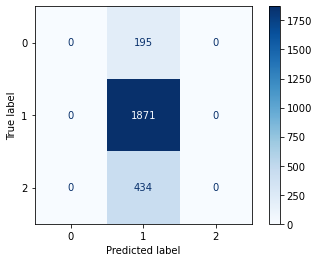

In [11]:
ConfusionMatrixDisplay.from_estimator(null_model, X_test, y_test, cmap='Blues');

**Observation** I will use this model to compare my other models too. Using the quick method of a dummy classifier, I have a null model accuracy of 74.8%. For a null model, I consider this high. I suspect the reason it is high, because the data is imbalanced. Now, I will decide between using the SMOTE method by oversampling or leaving it as it is. 

# Countvectorizer with Logistic Regression, 0.87

In [12]:
#Instantiate CountVectorizer & Logisticression
cvect = CountVectorizer(stop_words='english')
logreg = LogisticRegression(max_iter=10_000)

#Using a pipeline to expedite the model with params
pipe1 = make_pipeline(
    cvect,
    logreg
)

#Choice of params
params1 = {
    'countvectorizer__min_df': [0],
    'countvectorizer__max_df': [0.9, 1],
    'countvectorizer__ngram_range': [(1,2)]
}

#Using gridsearch to have better options for the model
gs1 = GridSearchCV(pipe1, params1, n_jobs=-1)

#Fit the model
gs1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 1],
                         'countvectorizer__min_df': [0],
                         'countvectorizer__ngram_range': [(1, 2)]})

In [13]:
gs1.cv_results_

pd.DataFrame(gs1.cv_results_).loc[:, ['params', 'mean_test_score']].sort_values(by='mean_test_score')

,params,mean_test_score
1,"{'countvectorizer__max_df': 1, 'countvectorize...",0.749200
0,"{'countvectorizer__max_df': 0.9, 'countvectori...",0.868133


In [14]:
gs1.score(X_test, y_test)

0.874

In [28]:
y_preds1 = gs1.predict(X_test)
y_preds1

array([2, 1, 1, ..., 1, 2, 1])

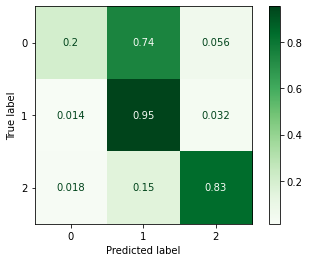

In [16]:
ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test, cmap='Greens', normalize='true');

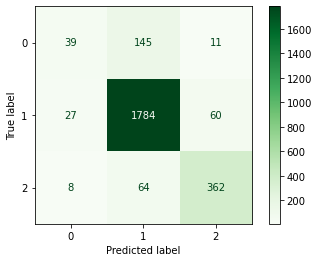

In [17]:
# hate_speech = 0, offensive language = 1, neither = 2
ConfusionMatrixDisplay.from_estimator(gs1, X_test, y_test, cmap='Greens');

**Observation** The model above has a score of 86%, which beats the null model by 12%. It shows that it correctly identified class 1 (offensive language) with 95% accuracy. Although, it did not do well in class 0 (hate speech). This can skew my question of whether the Twitter algorithm has a racial bias.  

In [29]:
balanced_accuracy_score(y_test, y_preds1)

0.6625340613995983

In [30]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_preds1))

              precision    recall  f1-score   support

           0       0.53      0.20      0.29       195
           1       0.90      0.95      0.92      1871
           2       0.84      0.83      0.84       434

    accuracy                           0.87      2500
   macro avg       0.75      0.66      0.68      2500
weighted avg       0.86      0.87      0.86      2500



# Lemmatizer with Logistic Reggression, 0.86

In [31]:
from nltk import word_tokenize
from nltk import WordNetLemmatizer

In [32]:
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [ self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [33]:
lemma = WordNetLemmatizer()
vect_lemmas = CountVectorizer(max_features=500, tokenizer=LemmaTokenizer())

X_train_lemmas = vect_lemmas.fit_transform(X_train)
X_test_lemmas = vect_lemmas.transform(X_test)

lr = LogisticRegression(max_iter=10_000, random_state=444)
lr.fit(X_train_lemmas, y_train)
lr.score(X_test_lemmas, y_test)

0.8604

In [37]:
balanced_accuracy_score(y_test, y_preds_lemma)

0.6719145320617709

In [35]:
y_preds_lemma =lr.predict(X_test_lemmas) 
y_preds_lemma

array([2, 1, 1, ..., 1, 2, 1])

In [38]:
print(metrics.classification_report(y_test, y_preds_lemma))

              precision    recall  f1-score   support

           0       0.48      0.24      0.32       195
           1       0.90      0.93      0.91      1871
           2       0.77      0.85      0.81       434

    accuracy                           0.86      2500
   macro avg       0.72      0.67      0.68      2500
weighted avg       0.85      0.86      0.85      2500



# Tfidf with Simple Logistic Regression, 0.86

In [40]:
#Instantiate TfidfVectorizer & Logistic Regression
tfidf_vect = TfidfVectorizer(stop_words='english')
logreg = LogisticRegression()

#Using a pipeline to expedite the model with params
pipe2 = make_pipeline(
    tfidf_vect,
    logreg
)

#Choice of params
params2 = {
"tfidfvectorizer__stop_words": ['english'],
"tfidfvectorizer__max_features": [10_000],
"tfidfvectorizer__ngram_range": [(1,2)]
}

#Used Gridsearchcv to help find the best options
gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)

#Fitting the model
gs2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__max_features': [10000],
                         'tfidfvectorizer__ngram_range': [(1, 2)],
                         'tfidfvectorizer__stop_words': ['english']})

In [41]:
gs2.cv_results_

pd.DataFrame(gs2.cv_results_).loc[:, ['params', 'mean_test_score']].sort_values(by = 'mean_test_score')


,params,mean_test_score
0,"{'tfidfvectorizer__max_features': 10000, 'tfid...",0.853733


In [42]:
gs2.score(X_test, y_test)

0.8588

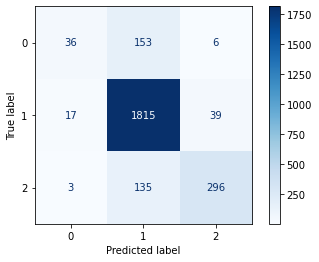

In [43]:
# hate_speech = 0, offensive language = 1, neither = 2
ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test, cmap='Blues');

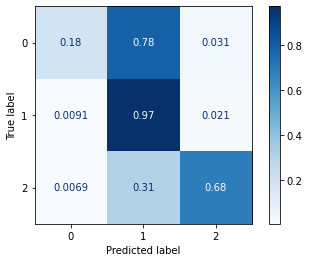

In [44]:
# hate_speech = 0, offensive language = 1, neither = 2
ConfusionMatrixDisplay.from_estimator(gs2, X_test, y_test, cmap='Blues', normalize='true');

In [45]:
y_preds2 = gs2.predict(X_test)
y_preds2

array([2, 1, 1, ..., 1, 2, 1])

In [46]:
balanced_accuracy_score(y_test, y_preds2)

0.6122375053152109

In [47]:
print(metrics.classification_report(y_test, y_preds2))

              precision    recall  f1-score   support

           0       0.64      0.18      0.29       195
           1       0.86      0.97      0.91      1871
           2       0.87      0.68      0.76       434

    accuracy                           0.86      2500
   macro avg       0.79      0.61      0.65      2500
weighted avg       0.85      0.86      0.84      2500



# Tfidf Logistic Regression with Hyperparameter of C value, 0.858

In [49]:
#Instantiate TfidfVectorizer & Logistic Regression
tfidf_vect = TfidfVectorizer(stop_words='english')
logreg = LogisticRegression(max_iter=10_000)

#Using a pipeline to expedite the model with params
pipe3 = make_pipeline(
    tfidf_vect,
    logreg
)

#Choice of params
params3 = {
"tfidfvectorizer__stop_words": ['english'],
"tfidfvectorizer__max_features": [10_000],
"tfidfvectorizer__ngram_range": [(1,2), (1,1)],
"logisticregression__C": [10, 100]
}

#Used Gridsearchcv to help find the best options
gs3 = GridSearchCV(pipe2, params2, n_jobs=-1)

#Fitting the model
gs3.fit(X_train, y_train) 

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__max_features': [10000],
                         'tfidfvectorizer__ngram_range': [(1, 2)],
                         'tfidfvectorizer__stop_words': ['english']})

In [50]:
gs3.cv_results_

pd.DataFrame(gs3.cv_results_).loc[:, ['params', 'mean_test_score']].sort_values(by='mean_test_score')



,params,mean_test_score
0,"{'tfidfvectorizer__max_features': 10000, 'tfid...",0.853733


In [51]:
gs3.score(X_test, y_test)

0.8588

In [52]:
y_preds3 = gs3.predict(X_test)
y_preds3

array([2, 1, 1, ..., 1, 2, 1])

In [61]:
balanced_accuracy_score(y_test, y_preds3)

0.6122375053152109

In [62]:
print(metrics.classification_report(y_test, y_preds3))

              precision    recall  f1-score   support

           0       0.64      0.18      0.29       195
           1       0.86      0.97      0.91      1871
           2       0.87      0.68      0.76       434

    accuracy                           0.86      2500
   macro avg       0.79      0.61      0.65      2500
weighted avg       0.85      0.86      0.84      2500



# CountVect & KNN Classifier, 0.81

In [53]:
pipe4 = make_pipeline(
    CountVectorizer(stop_words='english'),
    KNeighborsClassifier(),
)

params4 ={
"countvectorizer__ngram_range": [(1,2), (1,3)],
"countvectorizer__max_df": [0.9, 1],
"countvectorizer__min_df": [0],
"kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11],
"kneighborsclassifier__weights": ['uniform', 'distance']
}

gs4 = GridSearchCV(pipe4, params4, n_jobs=-1, cv=5)

gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 1],
                         'countvectorizer__min_df': [0],
                         'countvectorizer__ngram_range': [(1, 2), (1, 3)],
                         'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [54]:
gs4.cv_results_

pd.DataFrame(gs4.cv_results_).loc[:, ['params', 'mean_test_score']].sort_values(by='mean_test_score')

,params,mean_test_score
29,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748400
28,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748400
31,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
33,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
35,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
47,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
45,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
27,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667
43,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667
39,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667


In [55]:
gs4.score(X_test, y_test)

0.8132

In [63]:
y_preds4 = gs4.predict(X_test)
y_preds4

array([2, 1, 1, ..., 1, 2, 1])

In [64]:
balanced_accuracy_score(y_test, y_preds4)

0.6631665922816076

In [65]:
print(metrics.classification_report(y_test, y_preds4))

              precision    recall  f1-score   support

           0       0.48      0.23      0.31       195
           1       0.93      0.85      0.89      1871
           2       0.57      0.91      0.70       434

    accuracy                           0.81      2500
   macro avg       0.66      0.66      0.63      2500
weighted avg       0.83      0.81      0.81      2500



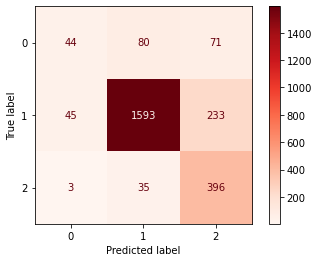

In [56]:
# hate_speech = 0, offensive language = 1, neither = 2
ConfusionMatrixDisplay.from_estimator(gs4, X_test, y_test, cmap='Reds');

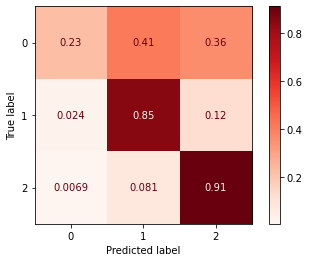

In [57]:
# hate_speech = 0, offensive language = 1, neither = 2
ConfusionMatrixDisplay.from_estimator(gs4, X_test, y_test, cmap='Reds', normalize='true');

# Tfidf KNN, 0.8132

In [58]:
tfidf_vect = TfidfVectorizer(
    stop_words='english',
    max_features=1_000,
    ngram_range=(1,2)
)

pipe5 = make_pipeline(
tfidf_vect,
KNeighborsClassifier()

)

params5 ={
"tfidfvectorizer__stop_words": ['english'],
"tfidfvectorizer__max_features": [10_000],
"tfidfvectorizer__ngram_range": [(1,2),(1,3)],
"kneighborsclassifier__n_neighbors": [1, 3, 5, 7, 9, 11],
"kneighborsclassifier__weights": ['uniform', 'distance'],

}

gs5 = GridSearchCV(pipe4, params4, n_jobs=-1)

gs5.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_df': [0.9, 1],
                         'countvectorizer__min_df': [0],
                         'countvectorizer__ngram_range': [(1, 2), (1, 3)],
                         'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']})

In [59]:
gs5.cv_results_

pd.DataFrame(gs5.cv_results_).loc[:, ['params', 'mean_test_score']].sort_values(by='mean_test_score')

,params,mean_test_score
29,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748400
28,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748400
31,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
33,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
35,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
47,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
45,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748533
27,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667
43,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667
39,"{'countvectorizer__max_df': 1, 'countvectorize...",0.748667


In [60]:
gs5.score(X_test, y_test)

0.8132

In [66]:
y_preds5 = gs5.predict(X_test)
y_preds5

array([2, 1, 1, ..., 1, 2, 1])

In [67]:
balanced_accuracy_score(y_test, y_preds5)

0.6631665922816076

In [68]:
print(metrics.classification_report(y_test, y_preds5))

              precision    recall  f1-score   support

           0       0.48      0.23      0.31       195
           1       0.93      0.85      0.89      1871
           2       0.57      0.91      0.70       434

    accuracy                           0.81      2500
   macro avg       0.66      0.66      0.63      2500
weighted avg       0.83      0.81      0.81      2500

